In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
np.random.seed(42)
%matplotlib inline

data_dir = '/Users/mbedell/python/pmodes/experiments/data/'

import utils

In [2]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP

In [3]:
xlim_data = np.array([10.2, 10.8]) * 86400 # for selecting all data
xlim_plot = [890000, 895000] # for zoomed-in plots

#### Try fitting a GP to a short timeseries of single-mode RV oscillations:

In [4]:
d = np.genfromtxt(data_dir+'sim_oneyear_onemode.csv', names=True, dtype=None, delimiter=',')
ts_onemode = np.copy(d['ts'])
rvs_onemode = np.copy(d['rvs'])
xs_onemode = np.copy(d['xs'])

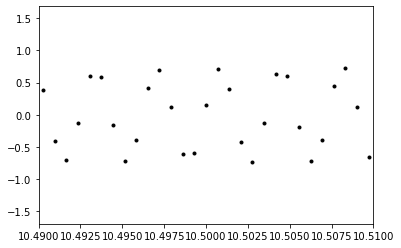

In [5]:
plt.plot(ts_onemode/86400., rvs_onemode, 'k.')
plt.xlim([10.49,10.51]);

In [6]:
inds = (ts_onemode > 10.49 * 86400) & (ts_onemode < 10.51 * 86400)
t = ts_onemode[inds]
y = rvs_onemode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 1000)
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
132it [00:00, 269.70it/s, logp=7.609279e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: 32.259569351810896 -> 76.09279191086408


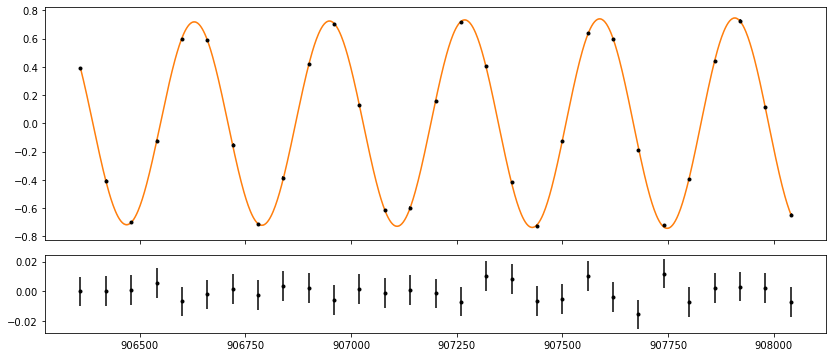

In [7]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids");

In [8]:
map_soln

{'logS0': array(-7.61159922),
 'logw0': array(-3.92939734),
 'logQ': array(9.86272682)}

This isn't quite what we expected - our calculation from `01-simulating-data.ipynb` was:
```
log_S0: -9.33721059
log_Q: 8.13423472
log_omega0: -3.92565541
```
BUT we do have an amplitudes issue when actually generating RVs from a GP with the above kernel and comparing to the RVs that we're using here, so maybe our expected logS0 is incorrect anyway.

#### Try with multi-mode RVs:

In [9]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_multimode = np.copy(d['ts'])
rvs_multimode = np.copy(d['rvs'])
xs_multimode = np.copy(d['xs'])

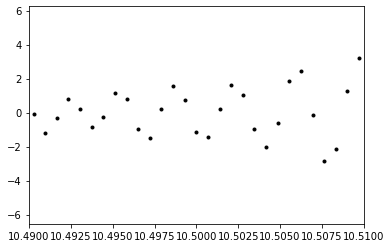

In [10]:
plt.plot(ts_multimode/86400., rvs_multimode, 'k.')
plt.xlim([10.49,10.51]);

In [11]:
inds = (ts_multimode > 10.49 * 86400) & (ts_multimode < 10.51 * 86400)
t = ts_multimode[inds]
y = rvs_multimode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 1000)
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
21it [00:00, 841.75it/s, logp=-1.431953e+01] 
message: Optimization terminated successfully.
logp: -153.67169156782754 -> -14.319532140086299


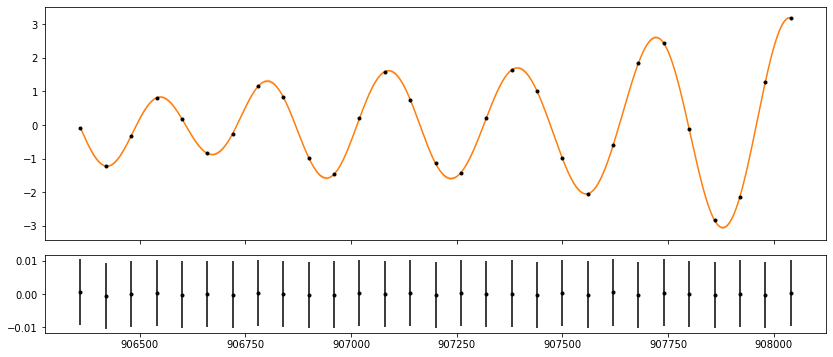

In [12]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids");

In [13]:
map_soln

{'logS0': array(0.68131953),
 'logw0': array(-3.89281373),
 'logQ': array(5.32584365)}

This is also an excellent fit, even though we only used one mode.

#### multi-mode RVs, sparser data:

In [14]:
inds = (ts_multimode > xlim_data[0]) & (ts_multimode < xlim_data[1])
t_all = ts_multimode[inds]
y_all = rvs_multimode[inds]
yerr_all = np.zeros_like(y_all) + 0.01 # 1 cm/s homogeneous error - made up!

In [15]:
inds = np.random.choice(np.arange(len(t_all)), size=200, replace=False)
inds.sort()
t = t_all[inds]
y = y_all[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 10000)

In [16]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
31it [00:00, 839.49it/s, logp=-2.216076e+02] 
message: Optimization terminated successfully.
logp: -2479.067175914414 -> -221.60761564676048


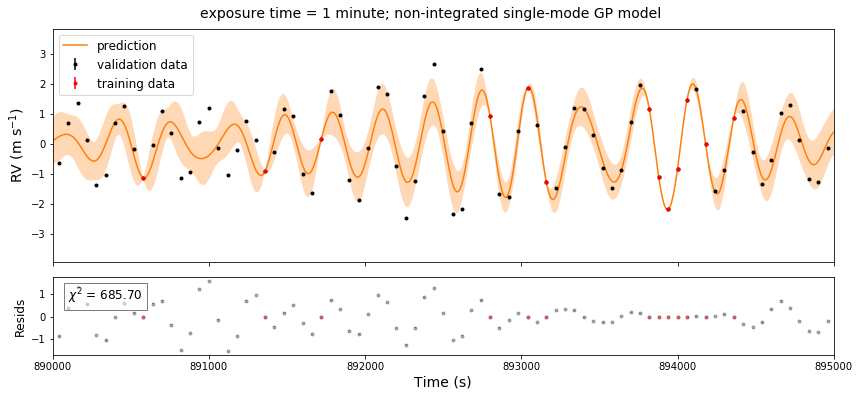

In [17]:
fig = utils.plot_validation_test(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14)
fig.savefig('GPvalidation_1min.png');

OK good, so this doesn't work perfectly well for predicting! Let's test whether the same predictions get any better if the GP kernel we use has the entire comb of modes.

In [18]:
a_max = 0.55 # amplitude of central mode in m/s
nu_max = 3.1e-3 # peak frequency in Hz
c_env = 0.331e-3 # envelope width in Hz
delta_nu = 0.00013 # Hz
gamma = 1. / (2 * 24. * 60. * 60.) # s^-1 ; 2-day damping timescale
dt = 50. # seconds - approximate Nyquist sampling

freq_grid = np.arange(nu_max - 0.001, nu_max + 0.001, delta_nu) # magic numbers
omega_grid = 2.*np.pi*freq_grid # angular frequencies
amp_grid = a_max**2 * np.exp(-(freq_grid-nu_max)**2/(2.*c_env**2)) # amplitudes in m/s
driving_amp_grid = np.sqrt(amp_grid * gamma * dt)
log_S0_grid = [np.log(d**2 / (dt * o)) for o,d in zip(omega_grid,driving_amp_grid)]

#print("log_S0_grid: {0}".format(log_S0_grid))
#print("log(omega_grid): {0}".format(np.log(omega_grid)))
#print("log(Q_grid): {0}".format(np.log(omega_grid/gamma)))

##### note: the following code is quite slow. maybe should do this hierarchically.

Try this as a hierarchical model with the following:

hyperparameters $\nu_{max}$, $\Delta\nu$, $a_{max}$, $c_{env}$, $\gamma$

**Note:** Not sure about use of gamma; also, might be missing some $2\pi$ factors due to $\nu$/$\omega$ inconsistencies.

### Longer-integration observations

Now that we're satisfied the GP works in general, let's test how it performs for observations that are integrated over longer times.

In [19]:
inds = (ts_multimode > 10.2 * 86400) & (ts_multimode < 10.8 * 86400)
exp_time = 5. * 60. #seconds
start_ts = ts_multimode[inds]
mid_rvs = np.array([utils.simulate_exposure(ts_multimode, rvs_multimode, tt, exp_time) for tt in start_ts])
mid_ts = start_ts + exp_time/2.

In [20]:
t_all = mid_ts
y_all = mid_rvs
yerr_all = np.zeros_like(y_all) + 0.01 # 1 cm/s homogeneous error - made up!

inds = np.random.choice(np.arange(len(t_all)), size=200, replace=False)
inds.sort()
t = mid_ts[inds]
y = mid_rvs[inds]
yerr = yerr_all[inds]
t_grid = np.linspace(t[0], t[-1], 10000)

#### integrated exposures modeled with single-SHO kernel non-integrated GP:

In [21]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
29it [00:00, 870.01it/s, logp=1.712876e+02]  
message: Optimization terminated successfully.
logp: 87.315448189854 -> 171.28764713507044


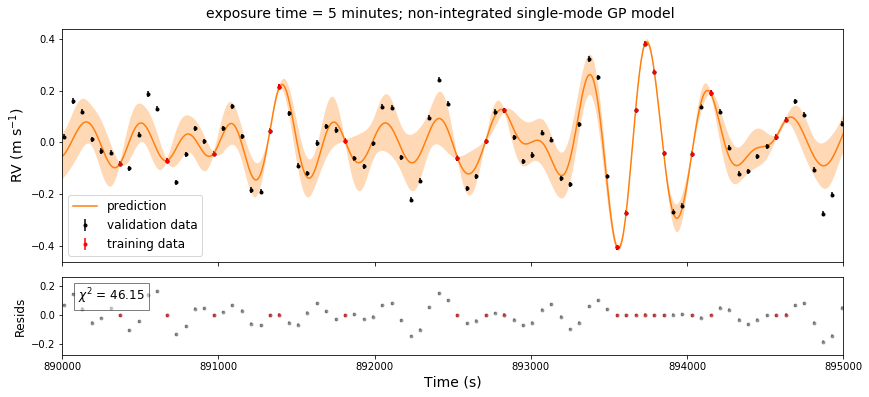

In [22]:
fig = utils.plot_validation_test(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
fig.savefig('GPvalidation_{0:.0f}min_nonintegrated.png'.format(exp_time/60.));

In [23]:
print(map_soln)

{'logS0': array(-1.8644931), 'logw0': array(-4.0671602), 'logQ': array(1.90401825)}


#### integrated exposures modeled with single-SHO kernel integrated GP:

In [29]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=5.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=5.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    kernel_int = terms.IntegratedTerm(kernel, exp_time)
    gp = GP(kernel_int, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
23it [00:00, 705.61it/s, logp=1.350584e+02]
message: Optimization terminated successfully.
logp: -589.5377402319788 -> 135.05842463390977


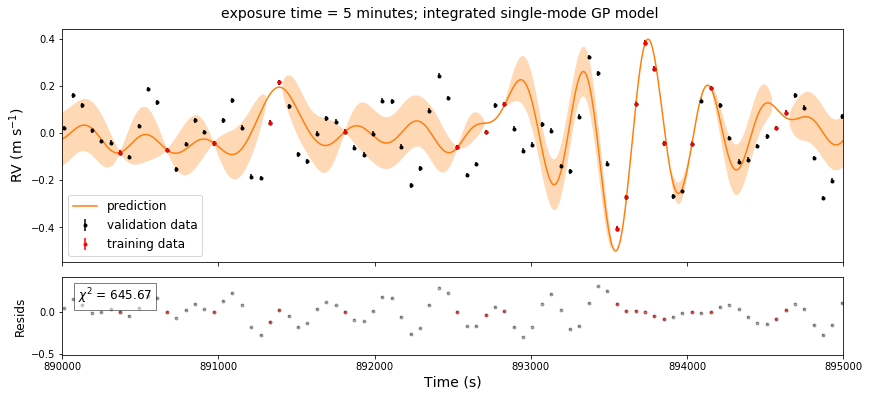

In [30]:
fig = utils.plot_validation_test(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
fig.savefig('GPvalidation_{0:.0f}min_integrated.png'.format(exp_time/60.));

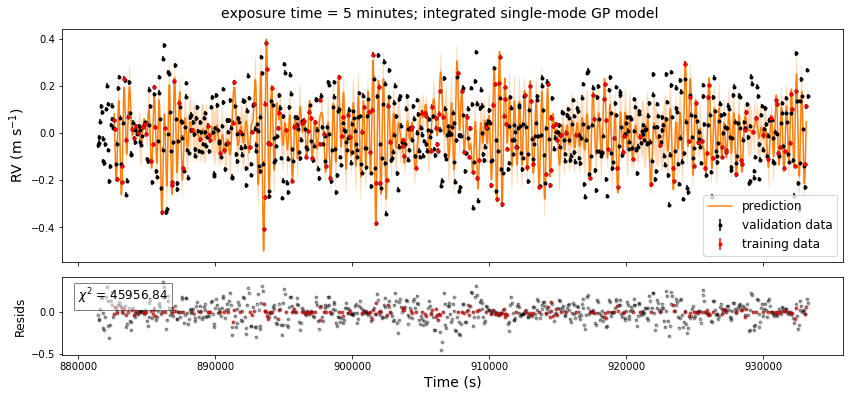

In [31]:
fig = utils.plot_validation_test_full(t, y, yerr, y_pred, t_all, y_all, yerr_all, y_pred_all, t_grid, mu, sd)
fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14);

In [32]:
print(map_soln)

{'logS0': array(-0.0702277), 'logw0': array(-4.04546791), 'logQ': array(2.76362795)}
